In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import regex as re
import gensim
from gensim.models import Word2Vec
from gensim.models import FastText
from numpy import mean

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE

from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

In [3]:
df=pd.read_csv(r'C:\Users\gEBRUIKER\OneDrive - Bull Aviation\Documents\job seeking\Data Wizards\Data Wizards - NLP Case\dataset.csv',delimiter=';')

In [4]:
display(df)

,description,fraudulent
0,"Food52, a fast-growing, James Beard Award-winn...",0
1,Organised - Focused - Vibrant - Awesome!Do you...,0
2,"Our client, located in Houston, is actively se...",0
3,THE COMPANY: ESRI – Environmental Systems Rese...,0
4,JOB TITLE: Itemization Review ManagerLOCATION:...,0
...,...,...
17875,Just in case this is the first time you’ve vis...,0
17876,The Payroll Accountant will focus primarily on...,0
17877,Experienced Project Cost Control Staff Enginee...,0
17878,Nemsia Studios is looking for an experienced v...,0


# Exploratory Analysis

In [5]:
#Checking duplicates
df.duplicated().sum()

3077

In [6]:
#Checking null values
df.isnull().sum()

description    1
fraudulent     0
dtype: int64

In [7]:
#value counts 
df['fraudulent'].value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

In [8]:
#Removing duplicates & missing values
df=df.drop_duplicates()
df=df.dropna()

In [9]:
#value counts after cleaning
df['fraudulent'].value_counts()

fraudulent
0    14171
1      631
Name: count, dtype: int64

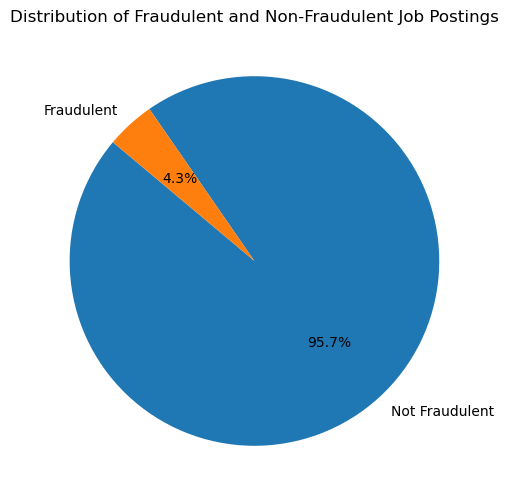

In [10]:
# Calculate the percentage of each class
fraudulent_percentage = df['fraudulent'].value_counts(normalize=True) * 100

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(fraudulent_percentage, labels=['Not Fraudulent', 'Fraudulent'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Fraudulent and Non-Fraudulent Job Postings')
plt.show()

# Data Preprocessing

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [12]:
def preprocess_text(text):
    text = text.str.replace(f"[{string.punctuation}]", "", regex=True)
    text = text.str.lower()
    text = text.str.split()
    text = text.apply(lambda x: [word for word in x if word not in stop_words])
    #text = text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    return text.str.join(" ")

In [13]:
%%time
df['description']=preprocess_text(df['description'])

CPU times: total: 234 ms
Wall time: 495 ms


In [14]:
df['description'][0]

'food52 fastgrowing james beard awardwinning online food community crowdsourced curated recipe hub currently interviewing full parttime unpaid interns work small team editors executives developers new york city headquartersreproducing andor repackaging existing food52 content number partner sites huffington post yahoo buzzfeed various content management systemsresearching blogs websites provisions food52 affiliate programassisting daytoday affiliate program support screening affiliates assisting affiliate inquiriessupporting pr amp events neededhelping office administrative work filing mailing preparing meetingsworking developers document bugs suggest improvements sitesupporting marketing executive staff'

# Text Embedding

In [15]:
def simple_tokenizer(text):
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = text.lower()
    tokens = re.split(r'\s+', text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [16]:
df['tokens']=df['description'].apply(simple_tokenizer)

In [17]:
tokenized_description=df['tokens'].tolist()

In [18]:
fasttext_model=FastText(sentences=tokenized_description,vector_size=100,window=5,min_count=1,workers=4)

In [19]:
def document_vector(tokens):
    # Filter tokens that are present in the Word2Vec model's vocabulary
    valid_tokens = [token for token in tokens if token in fasttext_model.wv]
    # Compute the mean of the vectors for the valid tokens
    if valid_tokens:
        return np.mean(fasttext_model.wv[valid_tokens], axis=0)
    else:
        return np.zeros(fasttext_model.vector_size)

In [20]:
# Apply the document vector function to each document
df['vector'] = df['tokens'].apply(document_vector)

# Convert list of vectors to a numpy array
X = np.array(df['vector'].tolist())

In [21]:
X

array([[-0.31762803,  0.14905576,  0.02017286, ...,  0.0735155 ,
        -1.0858381 , -0.9462185 ],
       [-0.2725653 ,  0.7739503 ,  0.00776705, ...,  0.05344537,
        -0.9927714 , -0.45319948],
       [-1.1334853 ,  1.0622977 ,  0.6094118 , ..., -0.37846905,
        -1.0536953 , -1.0145899 ],
       ...,
       [-1.17275   ,  0.43080074,  0.15756792, ..., -0.58174145,
        -1.0959519 , -0.3316493 ],
       [-0.57493913,  0.45059374, -0.5536635 , ..., -0.15404196,
        -1.3533893 , -0.42773026],
       [ 0.23951842,  0.14765637,  0.4686481 , ..., -0.37944147,
        -0.5002109 , -1.2016871 ]], dtype=float32)

# Training models

In [22]:
y = df['fraudulent']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The Fbeta-measure measure is an abstraction of the F-measure where the balance of precision and recall in the calculation of the harmonic mean is controlled by a coefficient called beta.

    Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)


In [23]:
#define F2 score
def f2(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=2)


    F0.5-Measure (beta=0.5): More weight on precision, less weight on recall.
    F1-Measure (beta=1.0): Balance the weight on precision and recall.
    F2-Measure (beta=2.0): Less weight on precision, more weight on recall

I'll be focusing on the F2-Measure since the emphasis is more on the False Negatives (Predicted Not Fraudulent while is Fraudulent), while taking into account the F1 score as a second metric.

In [39]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),#,class_weight='balanced'),
    #"LDA": LinearDiscriminantAnalysis(),
    #"Naive Bayes": GaussianNB(),
    #"KNN":KNeighborsClassifier(n_neighbors=16,metric='manhattan'),
    "DecisionTree":DecisionTreeClassifier(),
    "RandomForest":RandomForestClassifier()#class_weight='balanced'),
    #"GradientBoosting":GradientBoostingClassifier()
}
#

In [52]:
# Define a function to train the models and plot the F1 and F2 scores on a bar chart
def train_model_plot_f1_f2(models,X_train,y_train,X_text,y_test,title):
    f2_scores=[]
    f1_scores=[]
    #training all the models
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        F1score = f1_score(y_test,predictions)
        F2score = f2(y_test,predictions)
        f1_scores.append(F1score)
        f2_scores.append(F2score)
        
    #plotting F1 & F2 scores
    # Convert dictionary keys to list for consistent ordering
    model_names = list(models.keys())

    # Set the positions and width for the bars
    ind = np.arange(len(model_names))
    width = 0.35

    # Plot bars
    fig, ax = plt.subplots(figsize=(10, 6))
    bar1 = ax.bar(ind - width/2, f1_scores, width, label='F1 Score')
    bar2 = ax.bar(ind + width/2, f2_scores, width, label='F2 Score')

    # Add some text for labels, title and axes ticks
    ax.set_title('F1 and F2 Scores of Different Models: '+ title)
    ax.set_xticks(ind)
    ax.set_xticklabels(model_names, rotation=45)
    ax.legend()

    # Add grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Attach a text label above F1 and F2 bars to display the scores
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{:.3f}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    add_labels(bar1)
    add_labels(bar2)
    plt.show()
        

## Traditional models (no resampling)

In [40]:
results = {}
f2_scores=[]
f1_scores=[]
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, output_dict=True)
    conf_matrix = confusion_matrix(y_test, predictions)
    recall = recall_score(y_test,predictions)
    precision = precision_score(y_test,predictions)
    F1score = f1_score(y_test,predictions)
    F2score = f2(y_test,predictions)
    
    
    results[model_name] = {
        "model": model,
        "accuracy": accuracy,
        "f1_score" : f1_score,
        "recall": recall,
        "precision": precision,
        "f2-Score":F2score
    }
    
    f1_scores.append(F1score)
    f2_scores.append(F2score)

    print(f"{model_name} Results:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {F1score}")
    print(f"F2-Score: {F2score}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    print("\n ----------------")
    

Logistic Regression Results:
Accuracy: 0.7592029719689294
Precision: 0.14104193138500634
Recall: 0.75
F1-Score: 0.2374331550802139
F2-Score: 0.4024655547498187
Confusion Matrix:
[[2137  676]
 [  37  111]]

 ----------------
DecisionTree Results:
Accuracy: 0.9358324890239784
Precision: 0.3618421052631579
Recall: 0.3716216216216216
F1-Score: 0.3666666666666667
F2-Score: 0.36962365591397844
Confusion Matrix:
[[2716   97]
 [  93   55]]

 ----------------
RandomForest Results:
Accuracy: 0.9564336372847011
Precision: 0.88
Recall: 0.14864864864864866
F1-Score: 0.2543352601156069
F2-Score: 0.17828200972447328
Confusion Matrix:
[[2810    3]
 [ 126   22]]

 ----------------


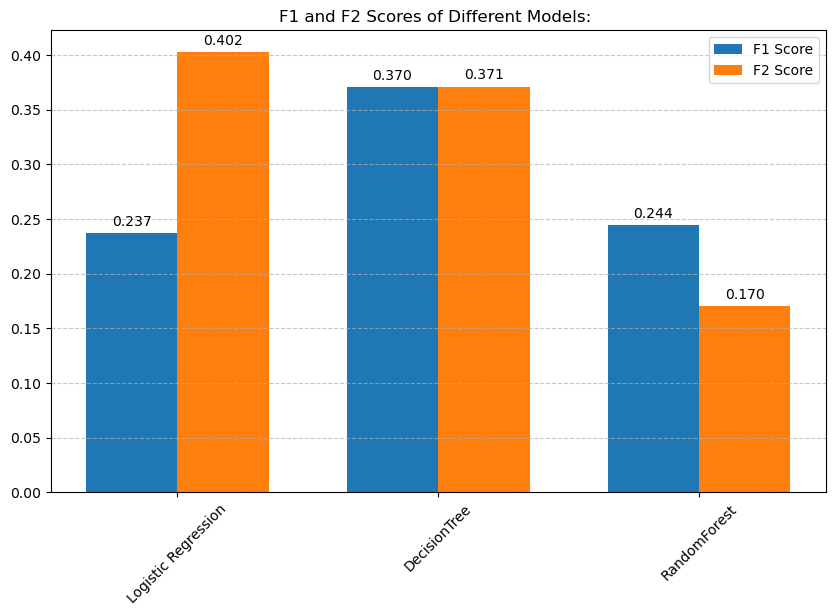

In [53]:
train_model_plot_f1_f2(models,X_train,y_train,X_test,y_test,"")

## Undersampling


In [27]:
undersampling_models = {
    "Random UnderSampler":RandomUnderSampler(random_state=42),
    "Tomek Links":TomekLinks(),
    "Repeated ENN":RepeatedEditedNearestNeighbours()
}

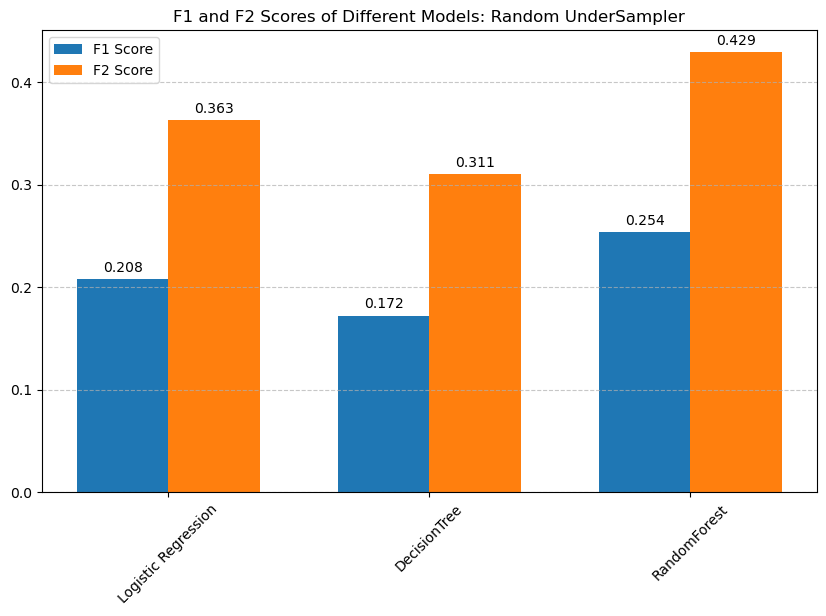

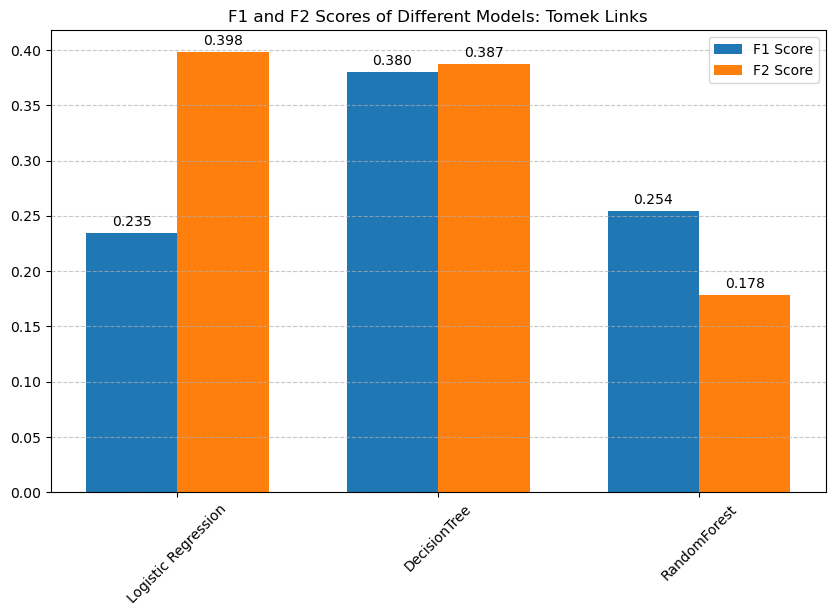

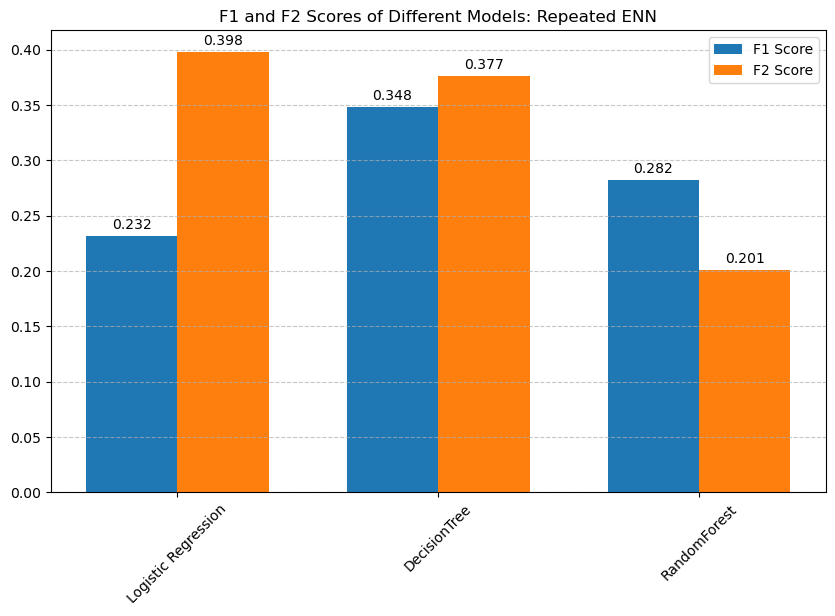

In [54]:
for und_mod_name, und_mod in undersampling_models.items():
    X_train_resampled, y_train_resampled = und_mod.fit_resample(X_train, y_train)
    train_model_plot_f1_f2(models,X_train_resampled,y_train_resampled,X_test,y_test,und_mod_name)

## Oversampling

In [55]:
oversampling_models = {
    "Random OverSampling":RandomOverSampler(random_state=42),
    "SMOTE":SMOTE(random_state=42),
    "ADASYN":ADASYN(random_state=42),
    "BorderlineSMOTE":BorderlineSMOTE(),
    "BorderlineSMOTESVM":SVMSMOTE()
}

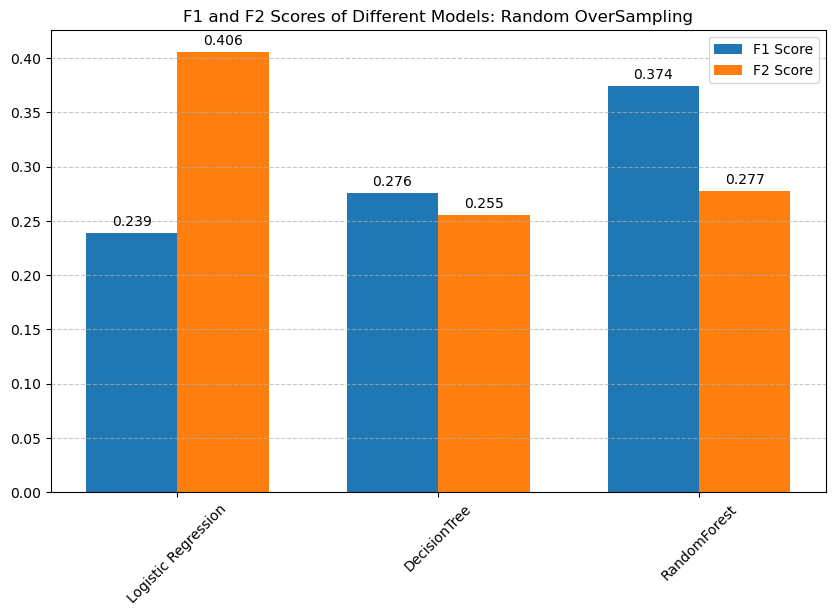

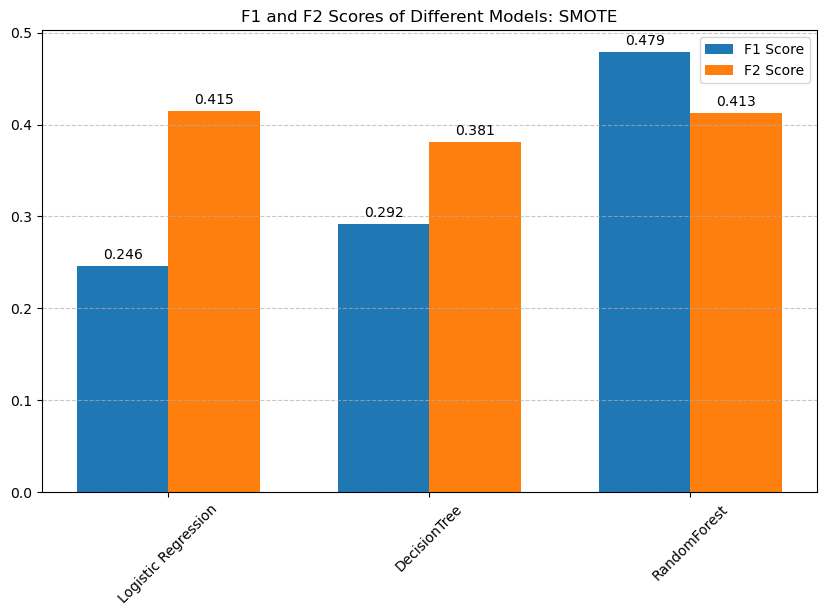

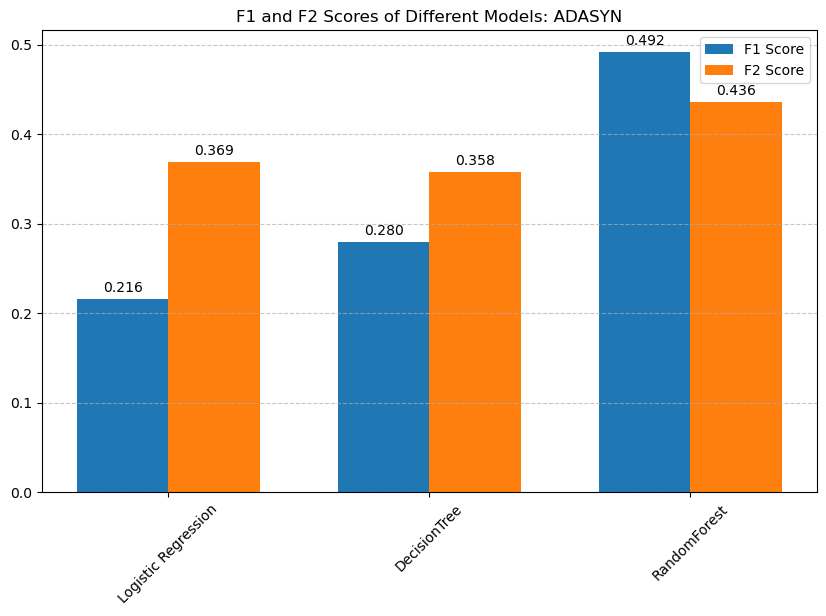

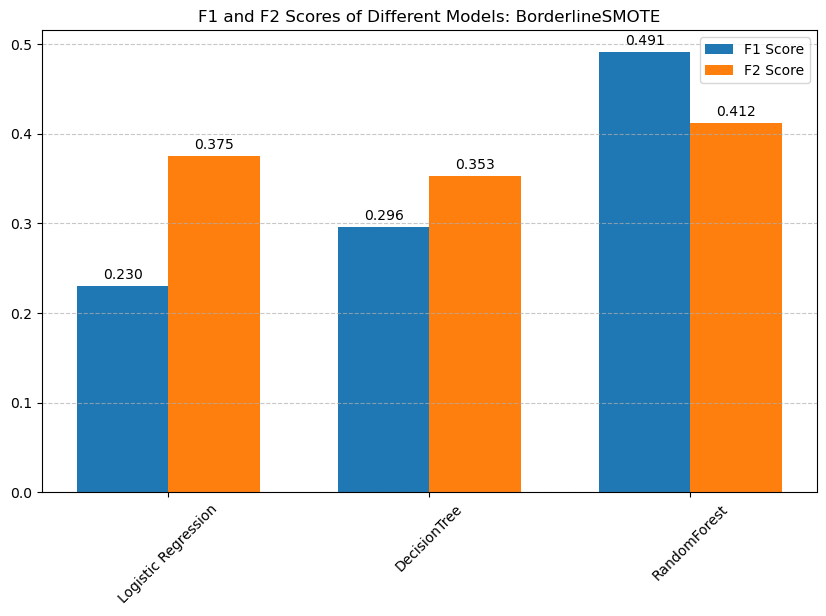

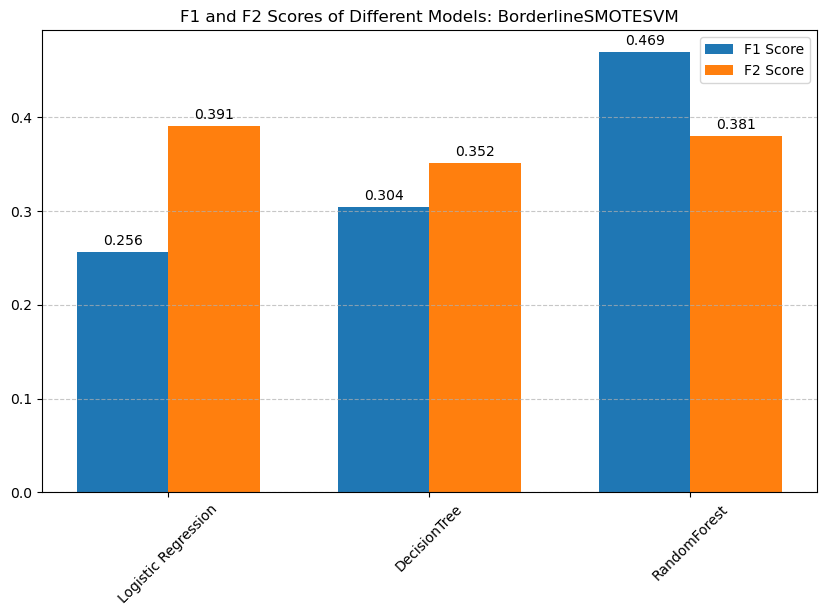

In [56]:
for over_mod_name, over_mod in oversampling_models.items():
    X_train_resampled, y_train_resampled = over_mod.fit_resample(X_train, y_train)
    train_model_plot_f1_f2(models,X_train_resampled,y_train_resampled,X_test,y_test,over_mod_name)

## fine-tuning
It seems like the best model is the *RandomForest Classifier* while using *ADASYN* for oversampling, let's see how we can fine-tune the model this model in order to have the best performance possible.

In [57]:
# Apply ADASYN
ada = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = ada.fit_resample(X_train, y_train)

### GridSearch

In [65]:
## Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [20, 30, None],
    'min_samples_split': [5, 10],
    'bootstrap': [True, False],
}

In [66]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

In [67]:
#define a custom scoring function
def custom_scorer(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2)
    #same weight for both
    return 0.5 * f1 + 0.5 * f2

In [68]:
# Initialize GridSearchCV with cross-validation
metric=make_scorer(custom_scorer)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring=metric)

In [69]:
# Perform the grid search on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F2 Score:", grid_search.best_score_)

Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best F2 Score: 0.8972201030388651


In [75]:
# Evaluate the best model on the test set
best_rf = grid_search.best_estimator_
predictions = best_rf.predict(X_test)

In [76]:
best_rf

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=5,
                       n_estimators=200, random_state=42)

## Saving the best model

In [78]:
import joblib

In [79]:
joblib.dump(best_rf, "RF_model_alpha.pkl")

['RF_model_alpha.pkl']

In [80]:
joblib.dump(fasttext_model, "fasttext_model_fraudulent.bin")

['fasttext_model_fraudulent.bin']